# [Text generation with an RNN Tutorial in TensorFlow 2.0](https://www.tensorflow.org/tutorials/text/text_generation)

This tutorial demonstrates how to generate text using a character-based RNN. We will work with a dataset of Shakespeare's writing from Andrej Karpathy's [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Given a sequence of characters from this data ("Shakespear"), train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

## Setup

In [1]:
import os
import pathlib
from pprint import pprint
import shutil
import time

import tensorflow as tf
import numpy as np

In [2]:
cwd = pathlib.Path(".").resolve()
print(cwd)

/content


## Download and read the data

In [3]:
# Download the Shakespeare dataset

path_to_file = pathlib.Path(tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'))
shakespeare_dataset_path = cwd / path_to_file.name
shutil.copy(str(path_to_file), str(shakespeare_dataset_path))
assert shakespeare_dataset_path.is_file()
print(shakespeare_dataset_path)

1122304/1115394 [==============================] - 0s 0us/step
/content/shakespeare.txt


In [4]:
 with open(shakespeare_dataset_path, "r") as fd:
   text = fd.read()
print(f"Length of text: {len(text)}")

Length of text: 1115394


In [5]:
# Take a look at the first 500 characters in text
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [6]:
# Get the unique set of characters in the file
vocabulary = sorted(set(text))
print(f"Vocabulary size: {len(vocabulary)}")
print()
print(vocabulary)

Vocabulary size: 65

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Process the text

### Vectorize the text
Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [7]:
char2idx = {c: i for i, c in enumerate(vocabulary)}
idx2char = np.array(vocabulary)

pprint(char2idx)

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'B': 14,
 'C': 15,
 'D': 16,
 'E': 17,
 'F': 18,
 'G': 19,
 'H': 20,
 'I': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64}


In [8]:
text_as_int = np.array([char2idx[c] for c in text])
print(f"'{text[:13]}' mapped to {text_as_int[:13]}")

'First Citizen' mapped to [18 47 56 57 58  1 15 47 58 47 64 43 52]


### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain seq_length characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of seq_length+1. For example, say seq_length is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the [`tf.data.Dataset.from_tensor_slices`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) function to convert the text vector into a stream of character indices.

In [9]:
seq_length = 100

In [10]:
examples_per_epoch = len(text) // (seq_length + 1)
print(f"Examples per epoch: {examples_per_epoch}")

Examples per epoch: 11043


In [11]:
# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [12]:
print(char_dataset)

<TensorSliceDataset shapes: (), types: tf.int64>


In [13]:
# Let's inspect how this dataset is formed
for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

F
i
r
s
t


In [14]:
# Let's create sequences of the desired length by means of batching
sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

In [15]:
for item in sequences.take(5):
  print(''.join(idx2char[item.numpy()]))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You 
are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you k
now Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us ki
ll him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be d
one: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citi


Now for each sequence we will duplicate and shift it to form the input and target text by using the map method to apply a simple function to each batch:

In [16]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

In [17]:
print(dataset)

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>


In [18]:
for input_seq, target_seq in dataset.take(2):
  print(f"Input sequence: {repr(''.join(idx2char[input_seq.numpy()]))}")
  print(f"Target sequence: {repr(''.join(idx2char[target_seq.numpy()]))}")

Input sequence: 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target sequence: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
Input sequence: 'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you '
Target sequence: 're all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'


In [19]:
for i, (input_idx, target_idx) in enumerate(zip(input_seq[:5], target_seq[:5])):
    print(f"Step {i:4d}")
    print(f"  input: {input_idx} ({repr(idx2char[input_idx])})")
    print(f"  expected output: {target_idx} ({repr(idx2char[target_idx])})")

Step    0
  input: 39 ('a')
  expected output: 56 ('r')
Step    1
  input: 56 ('r')
  expected output: 43 ('e')
Step    2
  input: 43 ('e')
  expected output: 1 (' ')
Step    3
  input: 1 (' ')
  expected output: 39 ('a')
Step    4
  input: 39 ('a')
  expected output: 50 ('l')


### Create training batches

We used `tf.data` to split the text into manageable sequences. But before feedings this data into the model, we need to shuffle the data and pack it into batches.

In [20]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

In [21]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>


## Build the model

Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model>
* tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
* tf.keras.layers.GRU: A type of RNN with size units=rnn_units (You can also use a LSTM layer here.)
* tf.keras.layers.Dense: The output layer, with vocab_size outputs.

In [22]:
vocab_size = len(vocabulary)
embedding_dim = 256
rnn_units = 1024

In [23]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  return tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, recurrent_initializer="glorot_uniform"),
    tf.keras.layers.Dense(vocab_size),
  ])

In [24]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:
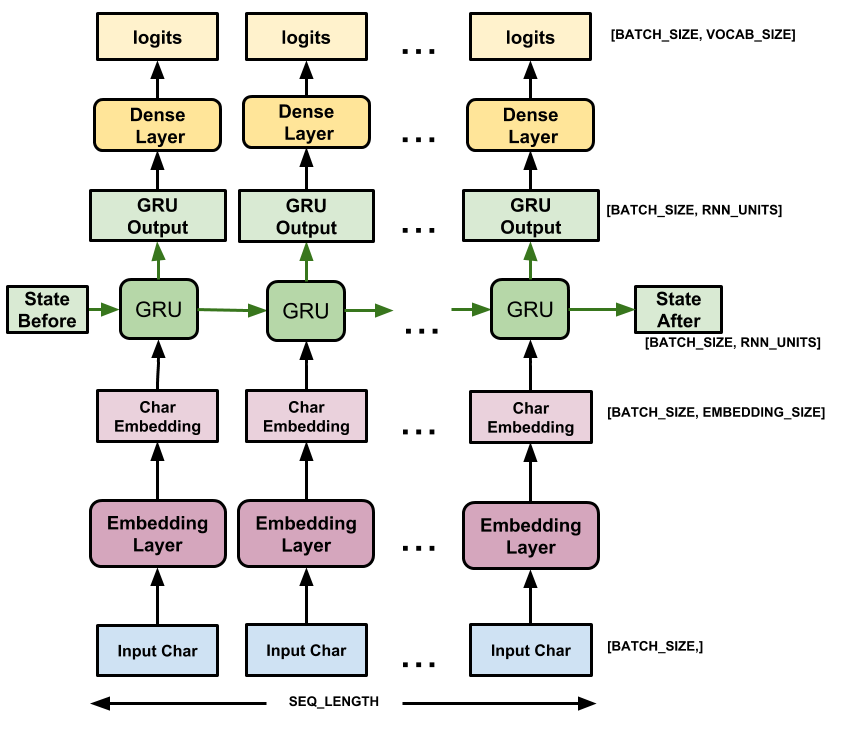

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [25]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

**Note: it is important to sample from this distribution as taking the argmax of the distribution can easily get the model stuck in a loop**

In [26]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [27]:
print(sampled_indices)

[47 61 39 43 57  4  4 24 57  6 55 64 62 54 20 60 29 19 57 33  0 13 12 21
 12 47 45 41 36 57 36  2 44 34 12 52 18  5 28  3 33 11 26 45  2 51  2 45
 35  0 43 55  8 48  4 26 49 22 30 39 12  8  8  0 13 51  6 15 59 30 34 25
 21  4 49 14 59 18 53 23 31 41 49 23 19 14 28 14 51 35 38 47 45 24 14 20
 11 34 26 37]


In [28]:
print("Input: \n", repr(''.join(idx2char[input_example_batch[0]])))
print()
print("Next char predictions\n", repr(''.join(idx2char[sampled_indices])))

Input: 
 'how can tyrants safely govern home,\nUnless abroad they purchase great alliance?\nTo prove him tyrant '

Next char predictions
 "iwaes&&Ls,qzxpHvQGsU\nA?I?igcXsX!fV?nF'P$U;Ng!m!gW\neq.j&NkJRa?..\nAm,CuRVMI&kBuFoKSckKGBPBmWZigLBH;VNY"


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Optimizer and loss function

In [29]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape)
print("Scalar loss: ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)
Scalar loss:  4.1736827


Configure the training procedure using the `tf.keras.Model.compile` method. We'll use `tf.keras.optimizers.Adam` with default arguments and the loss function.


In [30]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

In [31]:
checkpoint_dir = pathlib.Path('./training_checkpoints')
checkpoint_prefix = checkpoint_dir / "ckp_{epoch}"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=str(checkpoint_prefix), save_weights_only=True)

### Execute the training

In [32]:
EPOCHS = 40

In [33]:
history = model.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback],
)

Epoch 1/40
172/172 [==============================] - 9s 51ms/step - loss: 2.7152
Epoch 2/40
172/172 [==============================] - 9s 51ms/step - loss: 1.9675
Epoch 3/40
172/172 [==============================] - 9s 52ms/step - loss: 1.6980
Epoch 4/40
172/172 [==============================] - 9s 53ms/step - loss: 1.5481
Epoch 5/40
172/172 [==============================] - 9s 54ms/step - loss: 1.4594
Epoch 6/40
172/172 [==============================] - 9s 55ms/step - loss: 1.3989
Epoch 7/40
172/172 [==============================] - 10s 55ms/step - loss: 1.3531
Epoch 8/40
172/172 [==============================] - 10s 55ms/step - loss: 1.3145
Epoch 9/40
172/172 [==============================] - 9s 55ms/step - loss: 1.2806
Epoch 10/40
172/172 [==============================] - 9s 54ms/step - loss: 1.2479
Epoch 11/40
172/172 [==============================] - 9s 54ms/step - loss: 1.2151
Epoch 12/40
172/172 [==============================] - 9s 54ms/step - loss: 1.1853
Epoch 13/40

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1. Because of the way the RRN state is passed from timestep to timestep, the model only accepts a fixed batch size once built. To run the model with a different batch size, we need to rebuild the model and restore the weights from the checkpoint.

In [34]:
tf.train.latest_checkpoint(str(checkpoint_dir))

'training_checkpoints/ckp_40'

In [35]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(str(checkpoint_dir)))
model.build(tf.TensorShape([1, None]))

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


### Prediction loop

The following code block generates the text:

* It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.
* Get the prediction distribution of the next character using the start string and the RNN state.
* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.
* The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

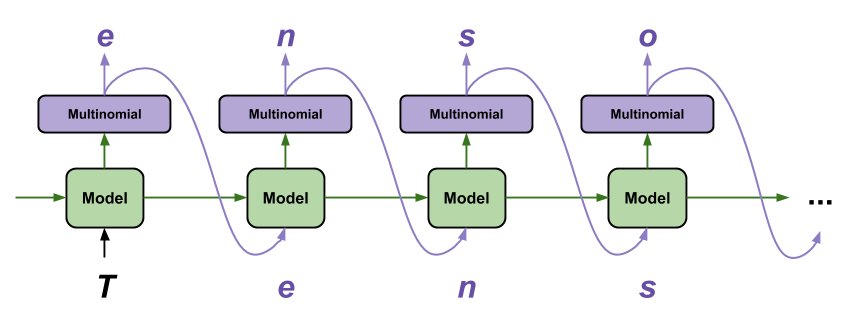

Looking at the generated text, you'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [37]:
def generate_text(model, start_string):
  # Number of characters to generate
  num_generate = 1000

  # converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text. Higher temperatures results in more surprising text.
  # Experiment to find the best setting
  temperature = 1.0

  # Here batch_size == 1
  for i in range(num_generate):
    predictions = model(input_eval)

    # Remove the batch dimension
    predictions = tf.squeeze(predictions, 0)

    # Use a categorical distribution to predict the character returned by the model
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

    # We pass the predicted character as the next input to the model along with the previous hidden state
    input_eval = tf.expand_dims([predicted_id], 0)
    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [38]:
print(generate_text(model, start_string="ROMEO: "))

ROMEO: Nay, mother.
Resume thy bird, he is of goor committ.

WARWICK:
Then fare you well, you canst not spy in thiedly offire,
The one my love's tooth; what I will, of women,
And this soon person: he has win in thee,
I will be teare:
Alas, I pray, sir, let him be here.

SOMERSET:
It multip so. eaten, you shall thank thee, here, Sibility, to whom we fear?
'Tis nothing but dead kindness, saying 'be;
And that the lords of Rome! or did well, be gone.

KING EDWARD IV:
And would so fair a horse day.

ISABELLA:
Unhappy dier two braved stinent.

His doth sink?
Thou know'st the villain Rude's Bushole?

BRUTUS:
You saw my state were even as sweet as gaunate
To lie Richard, then at the gracious word,
Your love supper; and, with these gone enough,
Shust undertake to lord, I take my leave,
To give the right husband, for whose sad dreadful wounds,
My mind enjoys thy side that loaring old,
When I should much opposed with frozen as I halve to die this mutty.

TRANIO:
Sir, I think she was of it, madam?

## Advanced: Customized Training

The above training procedure is simple, but does not give you much control.

So now that you've seen how to run the model manually let's unpack the training loop, and implement it ourselves. This gives a starting point if, for example, to implement curriculum learning to help stabilize the model's open-loop output.

We will use tf.GradientTape to track the gradients. You can learn more about this approach by reading the eager execution guide.

The procedure works as follows:

* First, initialize the RNN state. We do this by calling the tf.keras.Model.reset_states method.
* Next, iterate over the dataset (batch by batch) and calculate the predictions associated with each.
* Open a tf.GradientTape, and calculate the predictions and loss in that context.
* Calculate the gradients of the loss with respect to the model variables using the tf.GradientTape.grads method.
* Finally, take a step downwards by using the optimizer's tf.train.Optimizer.apply_gradients method.



In [39]:
 model = build_model(
     vocab_size = vocab_size,
     embedding_dim=embedding_dim,
     rnn_units=rnn_units,
     batch_size=BATCH_SIZE
)

In [40]:
optimizer = tf.keras.optimizers.Adam()

In [41]:
@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

In [42]:
# Training step
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)

    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(str(checkpoint_prefix).format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(str(checkpoint_prefix).format(epoch=epoch))

Epoch 1 Batch 0 Loss 4.1731462478637695
Epoch 1 Batch 100 Loss 2.3244211673736572
Epoch 1 Loss 2.1364
Time taken for 1 epoch 10.986966848373413 sec

Epoch 2 Batch 0 Loss 2.168898105621338
Epoch 2 Batch 100 Loss 1.9221484661102295
Epoch 2 Loss 1.8518
Time taken for 1 epoch 10.07288146018982 sec

Epoch 3 Batch 0 Loss 1.7989587783813477
Epoch 3 Batch 100 Loss 1.6843209266662598
Epoch 3 Loss 1.5972
Time taken for 1 epoch 9.923022031784058 sec

Epoch 4 Batch 0 Loss 1.5943890810012817
Epoch 4 Batch 100 Loss 1.5314160585403442
Epoch 4 Loss 1.4838
Time taken for 1 epoch 9.833257913589478 sec

Epoch 5 Batch 0 Loss 1.4634146690368652
Epoch 5 Batch 100 Loss 1.517702579498291
Epoch 5 Loss 1.4414
Time taken for 1 epoch 9.75699234008789 sec

Epoch 6 Batch 0 Loss 1.3843252658843994
Epoch 6 Batch 100 Loss 1.3663854598999023
Epoch 6 Loss 1.4000
Time taken for 1 epoch 9.789137840270996 sec

Epoch 7 Batch 0 Loss 1.3351950645446777
Epoch 7 Batch 100 Loss 1.3937214612960815
Epoch 7 Loss 1.3363
Time taken f